# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Arantxa Angulo

**Professor**: Pablo Camarillo Ramirez

# Introduction

## Problem Statement
Urban mobility is a critical challenge for modern cities. As populations grow, the corresponding increase in vehicles leads to severe traffic congestion, pollution, and increased travel times. This isn't just an inconvenience; it has significant economic impacts, costing hundreds of millions of dollars , and wastes valuable time—with estimates as high as 96 hours per driver annually in major cities.


A modern Master Traffic Control Center (MCC) aims to solve this by monitoring and processing traffic data in real-time. However, beyond real-time alerts, there is immense value in analyzing this data historically to identify long-term patterns, predict future congestion, and inform better urban planning.


## Project Objective
This project adapts the real-time MCC concept into a scalable batch processing pipeline. The objective is to build a robust system using Python and Apache Spark that can consume, transform, and persist large volumes of historical traffic data.

Instead of focusing on immediate alerts, this pipeline's goal is to ingest a "batch" of raw traffic data (simulated as 100 JSON files), process it, and create two types of persistence targets:

1. A "source of truth" table containing the raw, unmodified data for future analysis, fulfilling the need for historical data and ML training.
2. A set of clean, aggregated tables suitable for historical analysis, trend reporting, and business intelligence (BI) dashboards

In [1]:
import os
os.environ['PYSPARK_PYTHON'] = 'python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'python3'

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, from_unixtime, hour, date_format, first, last, avg, count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, BooleanType, ArrayType

# Initialize Spark Session with required JAR packages
spark = SparkSession.builder \
    .appName("TrafficBatchProcessing") \
    .config("spark.jars.packages", 
            "org.postgresql:postgresql:42.2.23") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

print("Spark Session created.")
# Verify the package is loaded
print("Checking loaded packages...")
packages = spark.sparkContext.getConf().get("spark.jars.packages", "")
print("Loaded packages:", packages)

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4341a295-267f-416d-ba51-15bb50a07145;1.0
	confs: [default]
	found org.postgresql#postgresql;42.2.23 in central
	found org.checkerframework#checker-qual;3.5.0 in central
:: resolution report :: resolve 122ms :: artifacts dl 4ms
	:: modules in use:
	org.checkerframework#checker-qual;3.5.0 from central in [default]
	org.postgresql#postgresql;42.2.23 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|     

Spark Session created.
Checking loaded packages...
Loaded packages: org.postgresql:postgresql:42.2.23


# Dataset

### Data Source
The dataset consists of 100 JSON files captured from the Waze Partner Hub API. These files were collected using a custom Python script (collect_data.py) that polled the API every two minutes, simulating a real-world data collection process over a period of 3+ hours. Each JSON file contains a complete snapshot of all traffic jams and alerts for the city of Leon, MX at that moment.

### Data Model and Schema
*Data Model*: The source data is in JSON (JavaScript Object Notation), a semi-structured, document-based data model. This format is highly flexible but contains deep nesting (arrays within objects) that must be processed.

*Schema*: A custom schema was defined using PySpark's StructType to read only the necessary jams array from the raw files. After the initial Explode and Transformation steps, the resulting clean and flattened DataFrame (cleaned_df) adheres to the following structured schema, which is the basis for all subsequent aggregations.

original dataset:
{
  "alerts": {
    "country",
    "city",
    "reportRating",
    "reportByMunicipalityUser",
    "confidence",
    "reliability",
    "type",
    "uuid",
    "roadType",
    "magvar",
    "subtype",
    "street",
    "reportDescription",
    "location": {
      "x",
      "y"
    },
    "pubMillis"
  },
  "endTimeMillis",
  "irregularities": {
    "country",
    "nThumbsUp",
    "updateDate",
    "trend",
    "city",
    "line": {
      "x",
      "y"
    },
    "detectionDateMillis",
    "type",
    "endNode",
    "speed",
    "seconds",
    "street",
    "jamLevel",
    "id",
    "nComments",
    "highway",
    "delaySeconds",
    "severity",
    "driversCount",
    "alertsCount",
    "length",
    "updateDateMillis",
    "nImages",
    "alerts": {
      "country",
      "city",
      "reportRating",
      "reportByMunicipalityUser",
      "confidence",
      "reliability",
      "type",
      "uuid",
      "roadType",
      "magvar",
      "subtype",
      "street",
      "location": {
        "x",
        "y"
      },
      "pubMillis"
    },
    "detectionDate",
    "regularSpeed",
    "startNode",
    "causeType",
    "causeAlert": {
      "country",
      "city",
      "reportRating",
      "reportByMunicipalityUser",
      "confidence",
      "reliability",
      "type",
      "uuid",
      "roadType",
      "magvar",
      "subtype",
      "street",
      "location": {
        "x",
        "y"
      },
      "pubMillis"
    }
  },
  "startTimeMillis",
  "startTime",
  "endTime",
  "jams": {
    "country",
    "level",
    "city",
    "line": {
      "x",
      "y"
    },
    "speedKMH",
    "length",
    "turnType",
    "uuid",
    "endNode",
    "speed",
    "segments": {
      "fromNode",
      "ID",
      "toNode",
      "isForward"
    },
    "blockingAlertUuid",
    "roadType",
    "delay",
    "street",
    "id",
    "pubMillis",
    "startNode"
  }
}

desired dataset:
Reportbymunicipalityuser, boolean
location_start, Struct(x, y)
location_end, Struct(x, y)
street_name, String
date, date
time, long # pubMillis
jamlevel, integer
country, string
city, tring
uuid, string # unique id

In [2]:
# Import custom utility
from arantxa.spark_utils import SparkUtils

# --- 1. Define the Raw Data Schema ---
# We define the structure needed to extract the 'jams' data.

# Schema for the 'line' objects: {"x": ..., "y": ...}
line_schema = ArrayType(
    StructType([
        StructField("x", DoubleType(), True),
        StructField("y", DoubleType(), True)
    ])
)

# Schema for the 'jams' objects
jams_schema = ArrayType(
    StructType([
        StructField("uuid", StringType(), True),
        StructField("street", StringType(), True),
        StructField("city", StringType(), True),
        StructField("country", StringType(), True),
        StructField("level", IntegerType(), True), # This is 'jamlevel'
        StructField("pubMillis", LongType(), True), # This is 'time'
        StructField("line", line_schema, True) # This contains start/end location
    ])
)

# Define the top-level schema for the entire JSON file.
# We only care about the 'jams' field.
final_raw_schema = StructType([
    StructField("jams", jams_schema, True)
])

# --- 2. Load the Data ---
# Define the path to your data
data_path = "/opt/spark/work-dir/data/leon_mx_traffic/" # Directory of JSON files 

# Read the data using our defined schema
# This is more efficient and safer than inferring the schema.
raw_df = spark.read \
    .schema(final_raw_schema) \
    .option("multiline", "true") \
    .json(data_path)

print("Raw data loaded with explicit schema.")
raw_df.printSchema()

Raw data loaded with explicit schema.
root
 |-- jams: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- uuid: string (nullable = true)
 |    |    |-- street: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- level: integer (nullable = true)
 |    |    |-- pubMillis: long (nullable = true)
 |    |    |-- line: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- x: double (nullable = true)
 |    |    |    |    |-- y: double (nullable = true)



# Persistence Data

A key requirement for this project is to save the raw, unprocessed data to serve as an immutable "source of truth." For this task, MongoDB is an ideal choice. Its high flexibility and native JSON-like document model align perfectly with the semi-structured JSON data coming from the Waze API. This ensures that all original data, including complex nesting, can be persisted with high fidelity and without schema conflicts , making it available for future re-analysis or machine learning applications

In [3]:
from pyspark.sql.functions import col, to_json, current_timestamp, monotonically_increasing_id

# --- 1. PostgreSQL Connection Configuration ---
postgres_url = "jdbc:postgresql://postgres-batch:5432/traffic_db"
postgres_properties = {
    "user": "postgres",
    "password": "Tempor@al", 
    "driver": "org.postgresql.Driver",
    "stringtype": "unspecified"  # This is the key for JSONB/JSON
}

# --- 2. Transform the DataFrame ---
print("Transforming DataFrame for PostgreSQL...")

# Create a new DataFrame with *only* the columns we can save to SQL.
# We select our new ID, timestamp, and the JSON string.
# This drops the original complex 'jams' column, which can't be saved.
df_to_save = raw_df.withColumn("raw_id", monotonically_increasing_id()) \
                   .withColumn("created_at", current_timestamp()) \
                   .withColumn("jams_json", to_json(col("jams"))) \
                   .select("raw_id", "created_at", "jams_json")

print("Schema of the DataFrame to be saved:")
df_to_save.printSchema()

# --- 3. Write to PostgreSQL ---
# This will create a new table named "raw_traffic_logs"
try:
    print("Writing raw JSON data to PostgreSQL...")
    df_to_save.write \
        .mode("overwrite") \
        .jdbc(url=postgres_url, 
              table="raw_traffic_logs", 
              properties=postgres_properties)
    
    print("✅ Successfully saved raw data to PostgreSQL!")

except Exception as e:
    print("❌ An error occurred during the write operation:")
    print(e)

Transforming DataFrame for PostgreSQL...
Schema of the DataFrame to be saved:
root
 |-- raw_id: long (nullable = false)
 |-- created_at: timestamp (nullable = false)
 |-- jams_json: string (nullable = true)

Writing raw JSON data to PostgreSQL...


[Stage 0:=====================================================>   (15 + 1) / 16]

✅ Successfully saved raw data to PostgreSQL!


# Transformations and Actions

The following code defines the core transformations for this pipeline. The process is as follows:

* *Explode*: The nested jams array within the raw DataFrame is "exploded" to create one distinct row per traffic jam.

* *Flatten & Clean*: The complex jam struct is flattened. Key fields (uuid, street_name, level, etc.) are selected. The array-based line data is processed using element_at() to extract a location_start and location_end struct. The pubMillis timestamp is converted to a standard, readable format.

* *Feature Engineering*: New, analysis-friendly columns (hour_of_day, day_name) are derived from the event timestamp. These are critical for building analytical dashboards.

* *Aggregation Definitions*: Three distinct aggregation DataFrames (street_summary_df, daily_summary_df, hourly_summary_df) are defined. These are transformations and do not trigger any Spark jobs; they are lazy-evaluated until an "action" (like .save()) is called.

In [4]:
from pyspark.sql.functions import col, explode, from_unixtime, hour, date_format, first, last, avg, count, element_at

# ---flatten the nested location data---
# Explode the 'jams' array. Each item in the 'jams' array will become a new row.
jams_df = raw_df.select(explode(col("jams")).alias("jam"))

print("Schema after exploding 'jams':")
jams_df.printSchema()

# Selecting desired fields 
cleaned_df = jams_df.select(
    col("jam.uuid").alias("uuid"),
    col("jam.street").alias("street_name"),
    col("jam.city").alias("city"),
    col("jam.country").alias("country"),
    col("jam.level").alias("jam_level"),
    col("jam.pubMillis").alias("pubMillis"),
    # Get the start and end of the jam from the 'line' array
    col("jam.line")[0].alias("location_start"),          
    element_at(col("jam.line"), -1).alias("location_end") 
)

# ---convert pubMillis to a readable timestamo---
cleaned_df = cleaned_df.withColumn("event_timestamp", \
    from_unixtime(col("pubMillis") / 1000).cast("timestamp"))

# ---drop duplicates based on the unique UUID--- 
cleaned_df = cleaned_df.dropDuplicates(["uuid"])

# drop columns we dont need
cleaned_df = cleaned_df.drop("pubMillis")

print("Cleaned and flattened schema:")
cleaned_df.printSchema()

### --------------------- feature engineering and aggregation
# Extract hour and day name for pattern analysis 
features_df = cleaned_df.withColumn("hour_of_day", hour(col("event_timestamp"))) \
                        .withColumn("day_name", date_format(col("event_timestamp"), "E")) # 'E' gives 'Mon', 'Tue', etc.

print("Schema with new features:")
features_df.printSchema()

### --------------------- aggregations
# main goal of batch pipeline: "real-time" dashboard, alerts to human handlers, powerbi/bigquery dashboards, historical analysis

# Aggregation 1: Average jam level and count by street
street_summary_df = features_df.groupBy("street_name") \
    .agg(
        avg("jam_level").alias("average_jam_level"),
        count("uuid").alias("jam_count")
    ) \
    .orderBy(col("jam_count").desc())

# Aggregation 2: Average jam level by day of the week
daily_summary_df = features_df.groupBy("day_name") \
    .agg(
        avg("jam_level").alias("average_jam_level"),
        count("uuid").alias("total_jams")
    ) \
    .orderBy(col("average_jam_level").desc())
        
# Aggregation 3: Busiest hours in the city
hourly_summary_df = features_df.groupBy("hour_of_day") \
    .agg(
        avg("jam_level").alias("average_jam_level"),
        count("uuid").alias("total_jams")
    ) \
    .orderBy(col("hour_of_day"))

print("Aggregations defined.")

Schema after exploding 'jams':
root
 |-- jam: struct (nullable = true)
 |    |-- uuid: string (nullable = true)
 |    |-- street: string (nullable = true)
 |    |-- city: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- level: integer (nullable = true)
 |    |-- pubMillis: long (nullable = true)
 |    |-- line: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- x: double (nullable = true)
 |    |    |    |-- y: double (nullable = true)

Cleaned and flattened schema:
root
 |-- uuid: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- jam_level: integer (nullable = true)
 |-- location_start: struct (nullable = true)
 |    |-- x: double (nullable = true)
 |    |-- y: double (nullable = true)
 |-- location_end: struct (nullable = true)
 |    |-- x: double (nullable = true)
 |    |-- y: double (nullable = true)
 |-- event

# Persistence Data

### Database Justification: PostgreSQL
For this project, PostgreSQL was chosen as the single persistence solution for two different purposes. While the raw data is JSON, PostgreSQL's advanced capabilities, including its JSONB and TEXT data types, make it an ideal "single source" for both raw and processed data.

This strategy provides two major benefits:

* Flexible Raw Storage: The raw, unprocessed JSON data is saved to a TEXT column in the raw_traffic_logs table. This serves as our immutable "source of truth," preserving the original data structure for future re-analysis or ML training.
* Structured Aggregate Storage: The final, aggregated DataFrames are clean, structured, and tabular. A relational database is the optimal model for this data.

This "two-pronged" approach simulates a modern data warehouse architecture. The aggregated tables (street_summary, etc.) are high-performance and ready for direct connection to BI tools like Tableau or Power BI, fulfilling the "Historical Dashboard" goal of the original design.

### Persistence Strategy
The code in this section executes the Spark 'actions' (.save()) that trigger all the defined transformations. The persistence is implemented as follows, all within the traffic_db database:

* Raw Data: The original raw_df is transformed to add a unique ID and timestamp, then saved to the raw_traffic_logs table.
* Aggregated Data: The three aggregated DataFrames (street_summary_df, daily_summary_df, hourly_summary_df) are saved as three separate, clean relational tables.

Critically, .mode("overwrite") is used for all write operations. This ensures that the pipeline is idempotent, meaning it can be re-run multiple times without duplicating data or causing errors. Each run will delete the old tables and replace them with the fresh, newly processed batch.

In [5]:
# Define the connection properties 
db_url = "jdbc:postgresql://postgres-batch:5432/traffic_db" 
db_driver = "org.postgresql.Driver" 
db_user = "postgres" 
db_password = "Tempor@al"  

# Write Aggregation 1 (Street Summary)
print("Persisting street_summary_df to PostgreSQL...")
street_summary_df.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", db_url) \
    .option("dbtable", "street_summary") \
    .option("user", db_user) \
    .option("password", db_password) \
    .option("driver", db_driver) \
    .save()

# Write Aggregation 2 (Daily Summary)
print("Persisting daily_summary_df to PostgreSQL...")
daily_summary_df.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", db_url) \
    .option("dbtable", "daily_summary") \
    .option("user", db_user) \
    .option("password", db_password) \
    .option("driver", db_driver) \
    .save()

# Write Aggregation 3 (Hourly Summary)
print("Persisting hourly_summary_df to PostgreSQL...")
hourly_summary_df.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", db_url) \
    .option("dbtable", "hourly_summary") \
    .option("user", db_user) \
    .option("password", db_password) \
    .option("driver", db_driver) \
    .save()

print("All aggregated data persisted to PostgreSQL.")

Persisting street_summary_df to PostgreSQL...


Persisting daily_summary_df to PostgreSQL...


Persisting hourly_summary_df to PostgreSQL...


[Stage 27:====================================================>   (15 + 1) / 16]

All aggregated data persisted to PostgreSQL.


# DAG

I will add multiple DAGs.

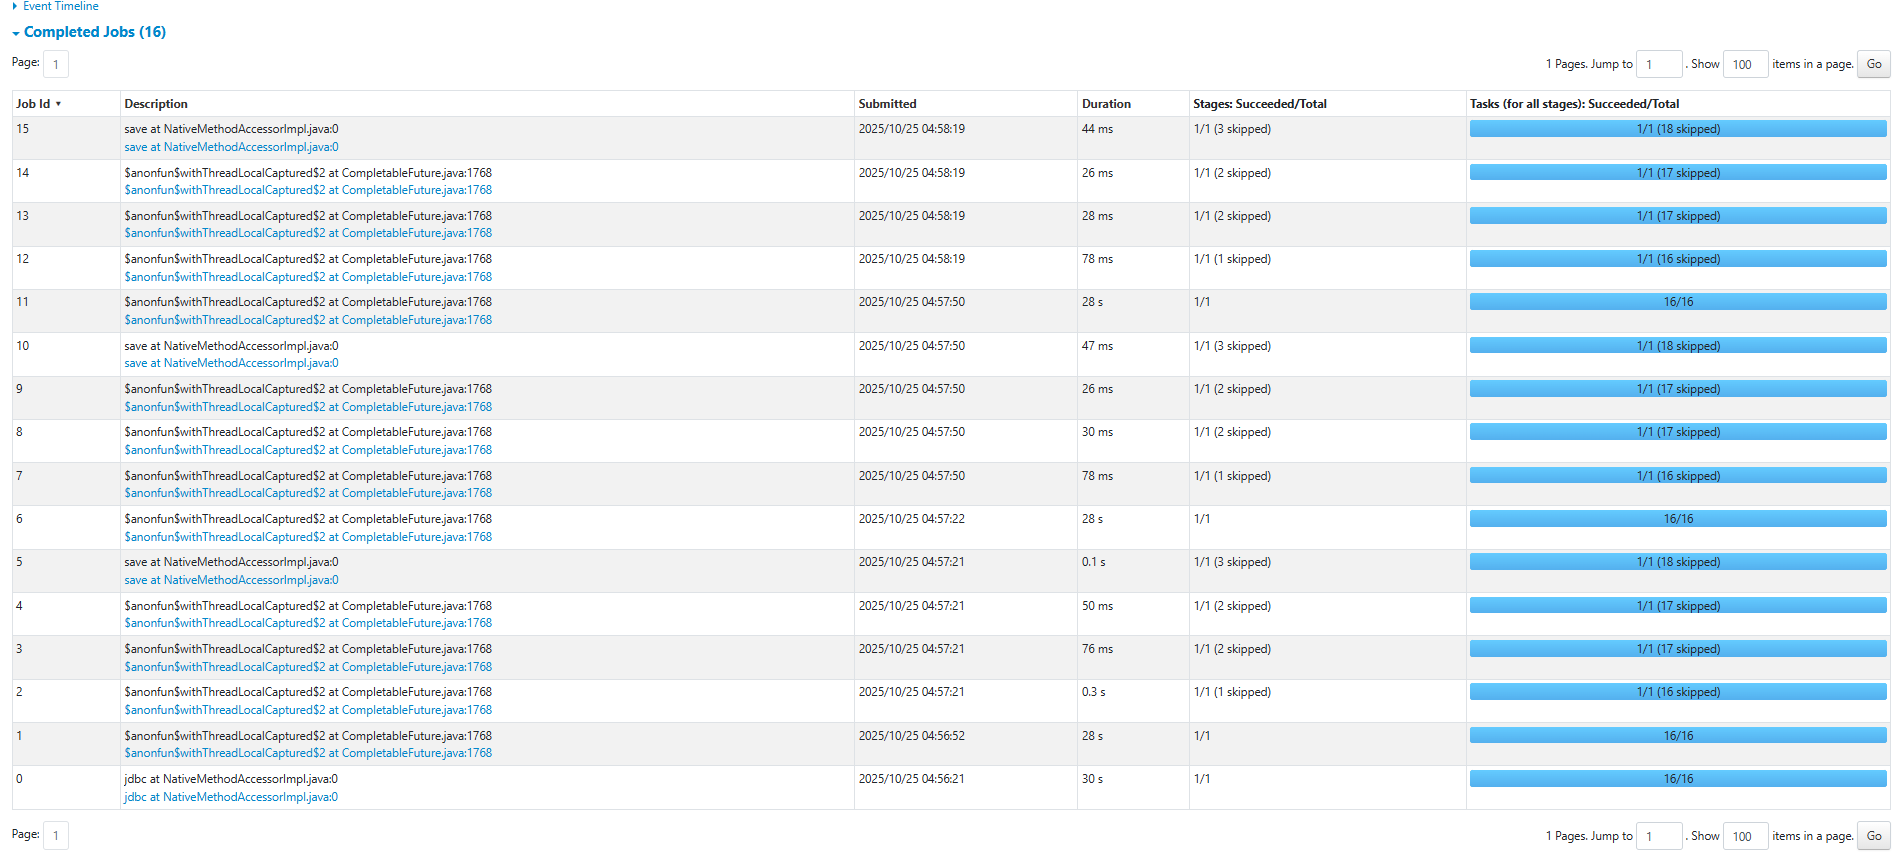

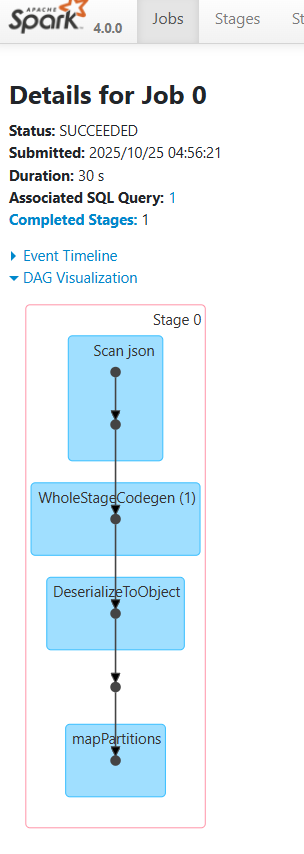

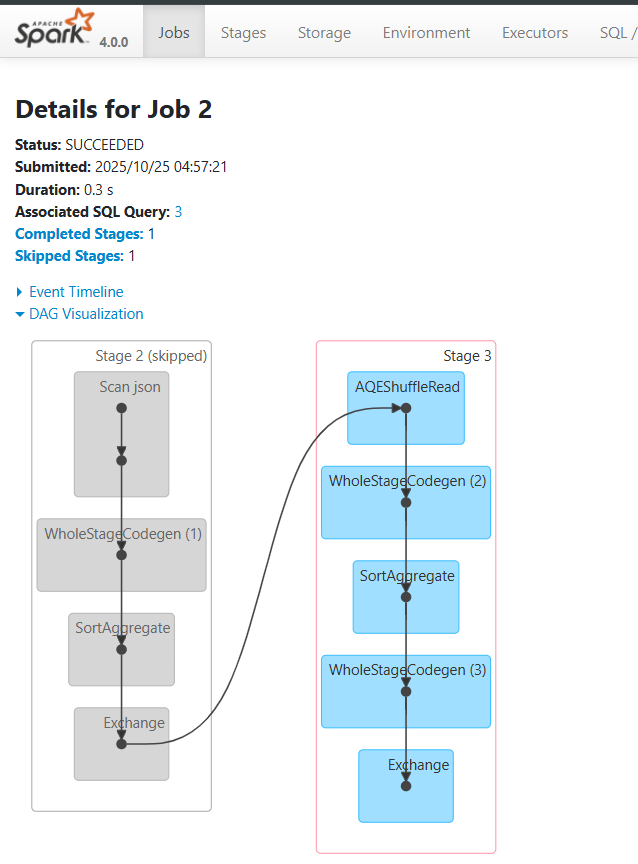

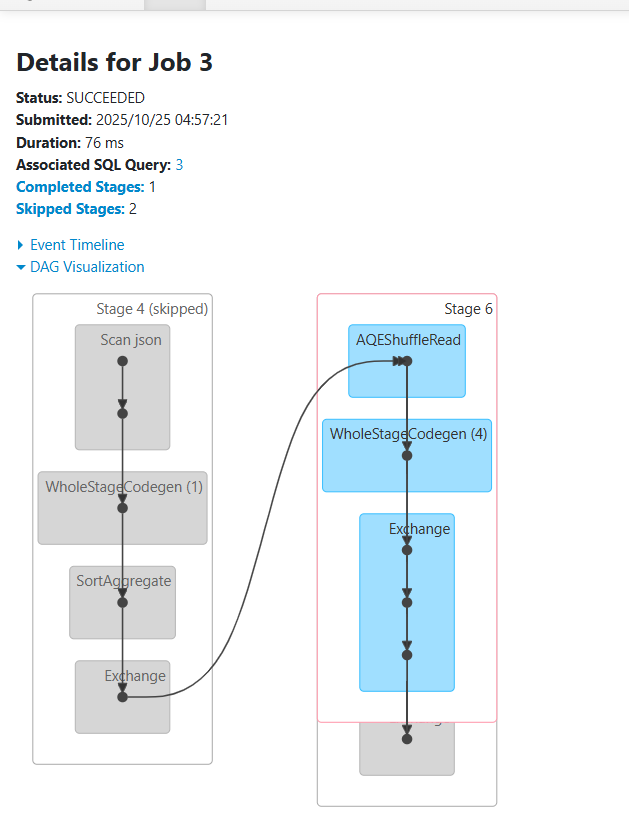

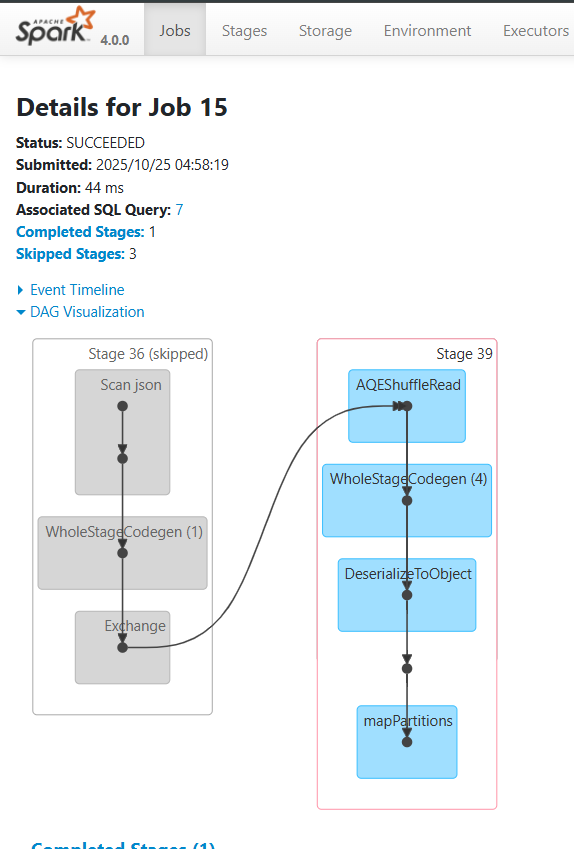

# EXTRA PROOF
I ran this query to see the results

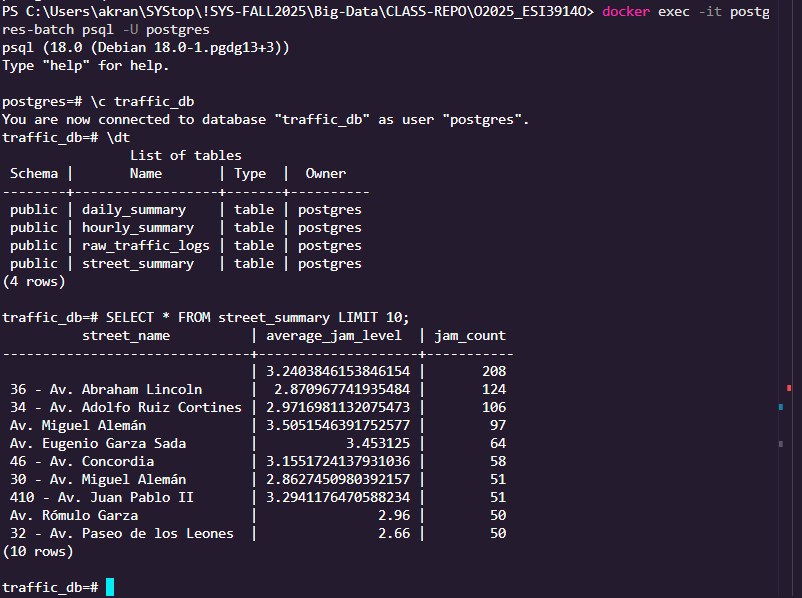

In [7]:
sc.stop()
spark.stop()